In [6]:
import os
import sys

assert "jax" not in sys.modules, "jax already imported: you must restart your runtime"
os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=4"

AssertionError: jax already imported: you must restart your runtime

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import pandas as pd

from epiweeks import Week

import jax
import jax.numpy as jnp
from jax.random import PRNGKey
from jax.typing import ArrayLike

import numpyro
import numpyro.distributions as dist

from pyrenew import model, process, latent, randomvariable, observation
from pyrenew.deterministic import DeterministicPMF,DeterministicVariable
import pyrenew.transformation as t
from pyrenew.randomvariable import TransformedVariable
from pyrenew.metaclass import RandomVariable
from pyrenew.randomvariable import DistributionalVariable
from pyrenew.latent import (
    Infections,
    InfectionInitializationProcess,
    InitializeInfectionsExponentialGrowth,
    InfectionsWithFeedback
)

import arviz as az


/Users/jingjieong/Projects/PyRenew/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Util functions

In [3]:
## plot utils
def format_quarterly_axis(ax):
    """
    Format a Matplotlib time axis to show quarterly ticks (Jan, Apr, Jul, Oct),
    with the year label shown only under January.
    """
    locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
    ax.xaxis.set_major_locator(locator)

    def _custom_fmt(x, pos):
        date = mdates.num2date(x)
        if date.month == 1:
            return f"{date.strftime('%b')}\n{date.year}"
        else:
            return date.strftime('%b')

    ax.xaxis.set_major_formatter(FuncFormatter(_custom_fmt))
    return ax

def conv(a: ArrayLike, b: ArrayLike) -> ArrayLike:
    """
    Helper function for convolution.
    """
    
    m = len(a)
    n = len(b)
    c = nc = np.zeros(m + n - 1)

    for i in range(m):       # Python index starts at idx
        for j in range(n):
            c[i + j] += a[i] * b[j]  # no -1 needed
    return c

## Data

In [4]:
d = pd.read_excel('../sg_data/agg_ari_ili.xlsx')

# Apply the Week conversion to each row
def get_dates(row):
    try:
        epi_week = Week(row['year'], row['epi_week'])
        return pd.Series({
            'start_date': epi_week.startdate(),
            'end_date': epi_week.enddate()
        })
    except Exception as e:
        return pd.Series({
            'start_date': None,
            'end_date': None
        })

# Apply the function and combine results
date_cols = d.apply(get_dates, axis=1)
d = pd.concat([d, date_cols], axis=1)

d['start_date'] = pd.to_datetime(d['start_date'])
d['end_date'] = pd.to_datetime(d['end_date'])

d['year_week'] = d['year'].astype(str) + "-" + d['epi_week'].astype(str)

d['ili_influenza_positivity'] = d['ili_influenza_pos'] / d['ili_samples']
d['ari_influenza_positivity'] = d['ari_influenza_pos'] / d['ari_samples']

surv_period = {'start': ['2023-18','2023-44','2024-18','2024-44','2025-18'],
              'end': ['2023-43','2024-17','2024-43','2025-17','2025-39']}

#flu case counts from poly attendances * positivity
d['est_flu_cases'] = d['poly_ari_attendances'] * d['ari_influenza_positivity']


### Visualising the pre-defined surveillance period

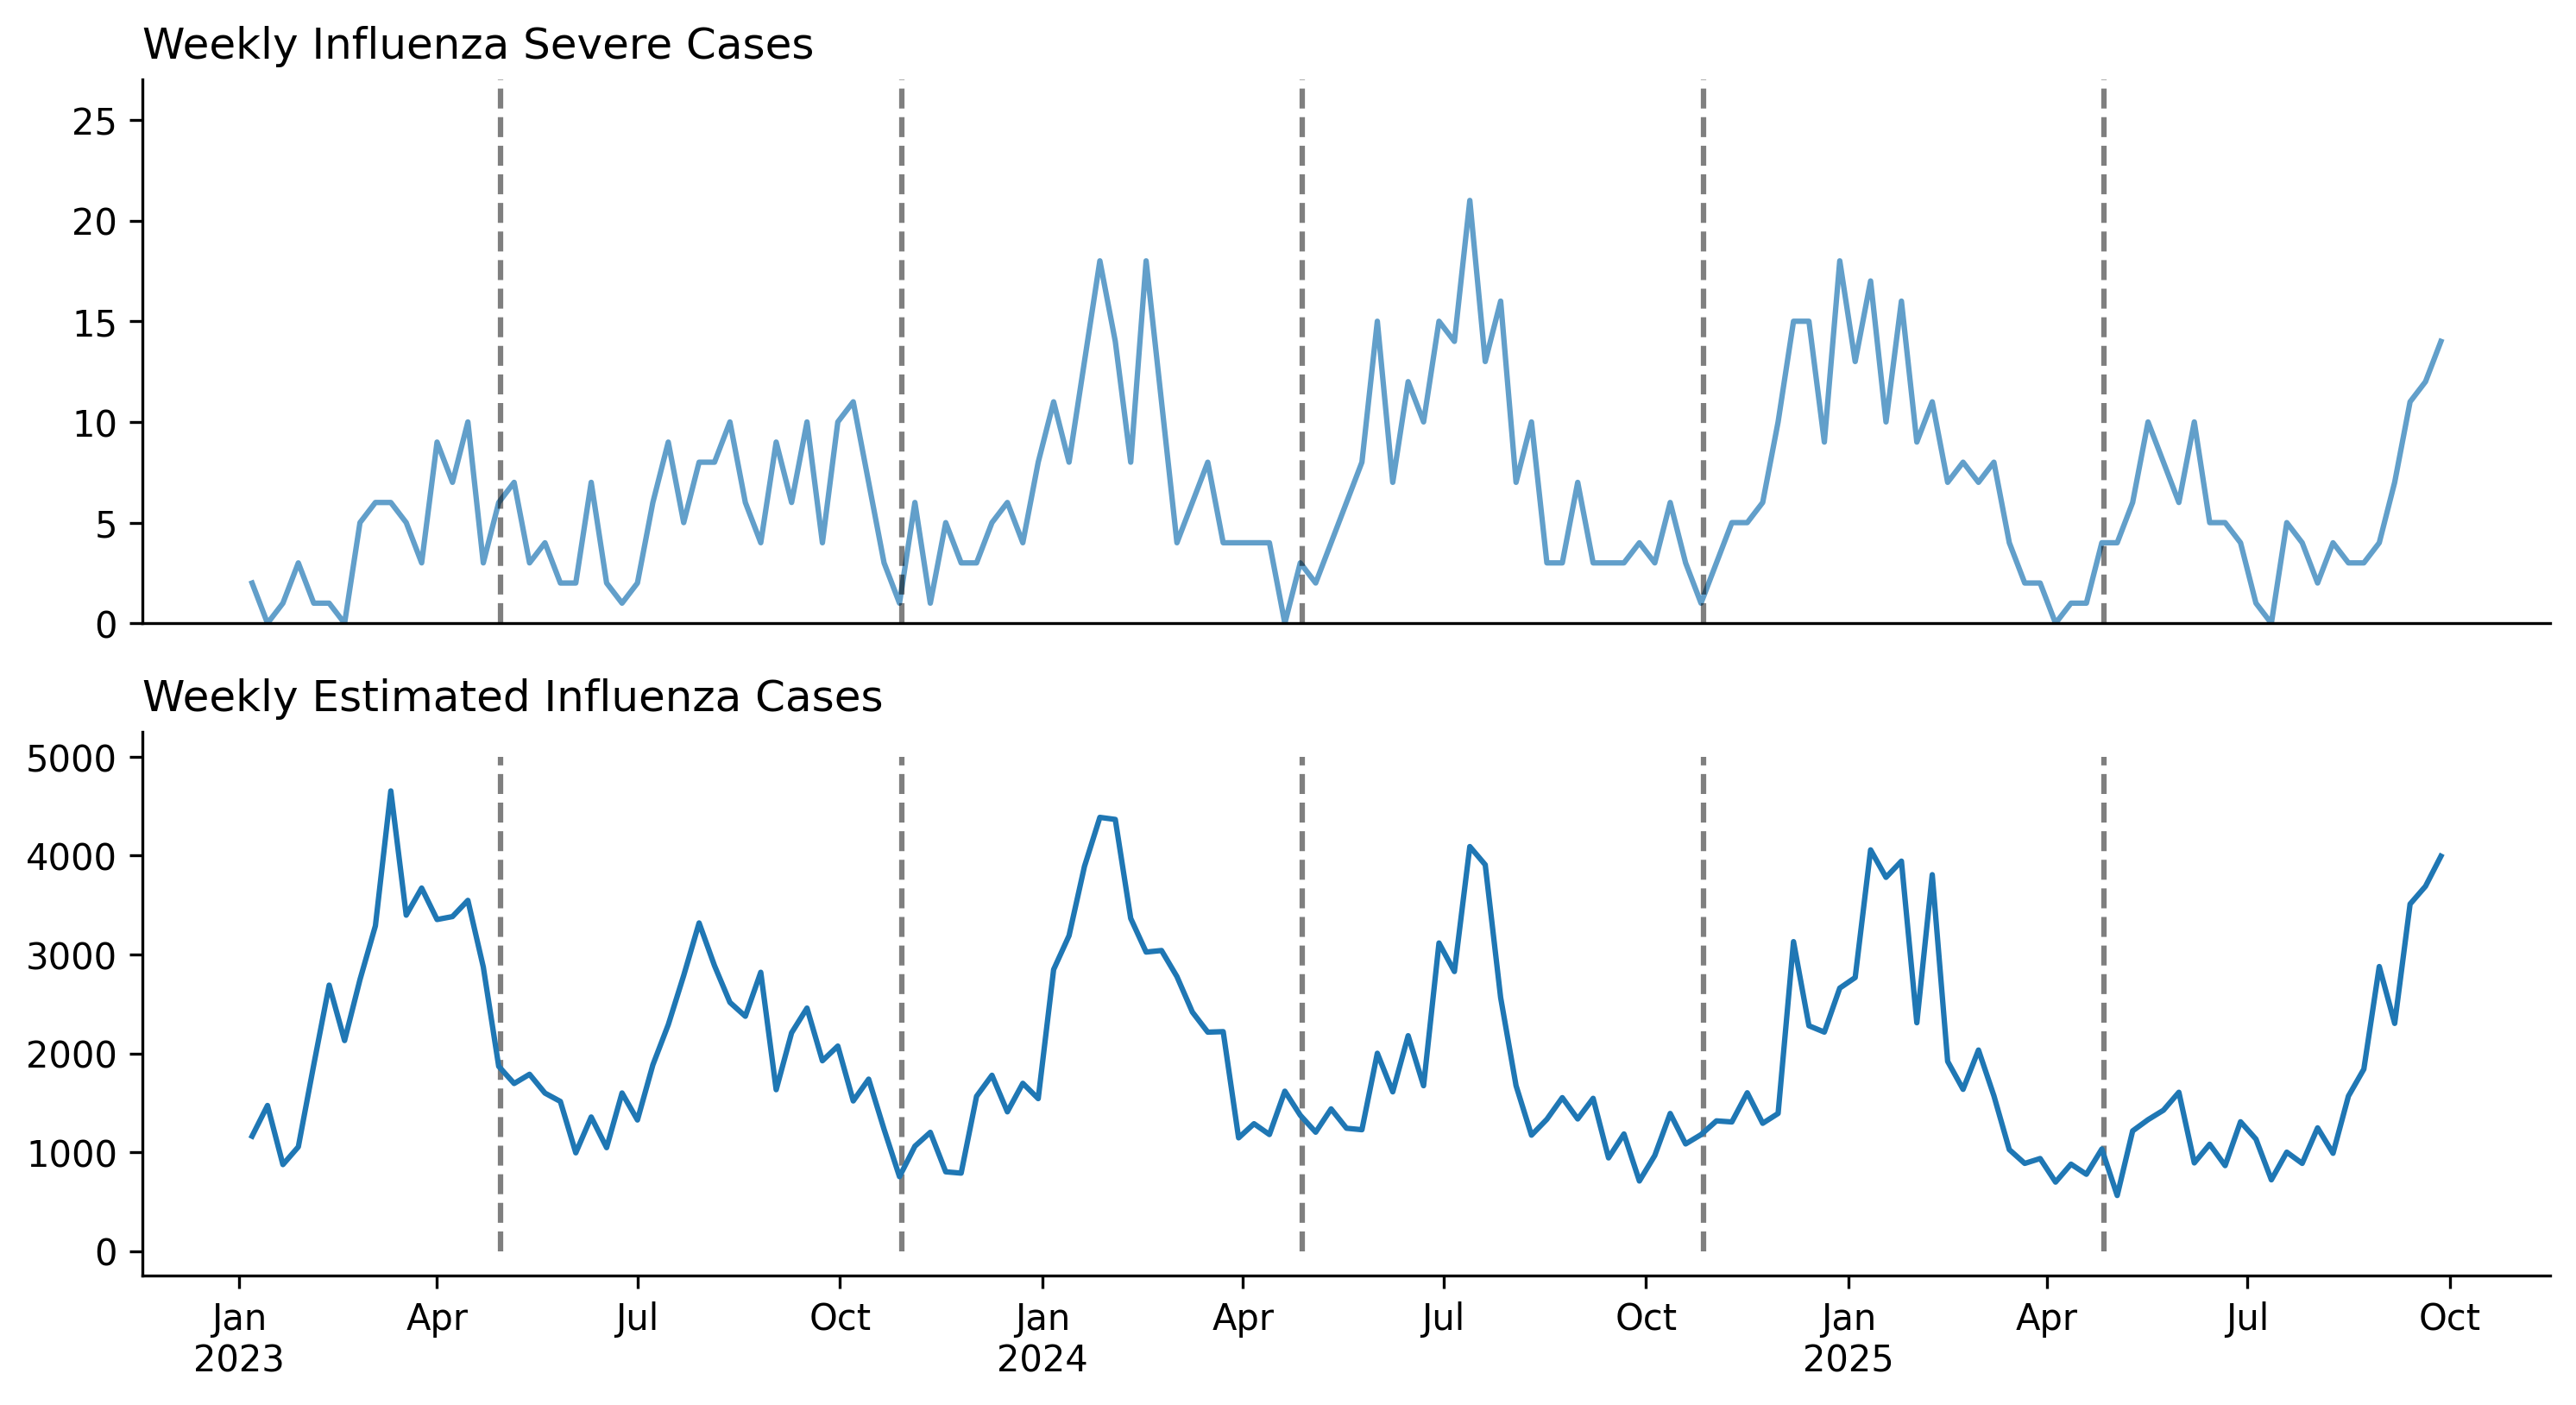

In [5]:
fig,ax = plt.subplots(2,1,figsize = (12,6),dpi=300)
plt.subplots_adjust(hspace = 0.2)

ax[0].plot(d['end_date'],d['severe_flu'], alpha = 0.7)

for v in surv_period['start']:
        ax[0].vlines(x = d[d['year_week'] == v]['start_date'], ymin = 0, ymax = 30, linestyles='dashed', alpha = 0.5, color = 'black')
        ax[1].vlines(x = d[d['year_week'] == v]['start_date'], ymin = 0, ymax = 5000, linestyles='dashed', alpha = 0.5, color = 'black')

ax[0].set_ylim(0,27)
ax[0].set_xticks([])

ax[1].plot(d['end_date'],d['est_flu_cases'])

for a in ax:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

# ax[1].xaxis.set_major_locator(mdates.MonthLocator())
# ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

format_quarterly_axis(ax[1])

ax[0].set_title("Weekly Influenza Severe Cases", loc = 'left')
ax[1].set_title("Weekly Estimated Influenza Cases", loc = 'left')

plt.show()

### Model 1 (Severe only): Set delay distributions and define ascertainment rates


In [110]:
## Generation time interval, Gamma(4.55,0.7) mean 3.2, sd = 1.5
x = jnp.arange(0,20)
gen_time_dist = dist.Gamma(concentration = 4.55, rate = 1/0.7)
gen_time_raw = jnp.exp(gen_time_dist.log_prob(x))
gen_time_norm = gen_time_raw / sum(gen_time_raw)

gen_time_rv = DeterministicPMF(name = 'gen_int', value = gen_time_norm)

## Incubation, Gamma(2.76,0.65) - Infection to symptoms onset = 1-4 days after infection (CDC)
x = jnp.arange(0,10)
incub_dist = dist.Gamma(concentration = 2.76, rate = 1/0.65) #mean = 1.8, sd = 1
incub_raw = jnp.exp(incub_dist.log_prob(x))
incub_norm = incub_raw / sum(incub_raw)

# Onset to severe, Gamma(6.25,0.8) - Onset to severe (6 days on average)
x = jnp.arange(0,15)
ons_severe_dist = dist.Gamma(concentration = 6.25, rate = 1.25) # mean = 5, sd = 2
ons_severe_raw = jnp.exp(ons_severe_dist.log_prob(x))
ons_severe_norm = ons_severe_raw / sum(ons_severe_raw)

# Infection to severe convolution
inf_severe_dist = DeterministicPMF('inf_sev_dist',conv(incub_norm,ons_severe_norm))

# Ascertainment rate for severe cases
class Alpha_severe(RandomVariable):
    def validate(self):
        pass

    def sample(self, n = None):
        p_sym = TransformedVariable('p_sym',base_rv = DistributionalVariable('p_sym_logodds',
                                                distribution= dist.Normal(0.85,0.6)),
                                    transforms=t.SigmoidTransform())
    
        p_sym = p_sym.sample()

        p_sev = TransformedVariable('p_sev',base_rv = DistributionalVariable('p_sev_logodds',
                                            distribution= dist.Normal(-5.3,1.0)),
                                transforms=t.SigmoidTransform())
        
        p_sev = p_sev.sample()

        p_rho = TransformedVariable('p_rho',base_rv = DistributionalVariable('p_rho_logodds',
                                        distribution= dist.Normal(1.39,0.6)),
                            transforms=t.SigmoidTransform())

        p_rho = p_rho.sample()

        alpha_severe = numpyro.deterministic('alpha_severe',p_sym*p_sev*p_rho)
        
        return alpha_severe

alpha_severe_rv = Alpha_severe()

#Latent hospital
latent_hosp = latent.HospitalAdmissions(
    infection_to_admission_interval_rv= inf_severe_dist,
    infection_hospitalization_ratio_rv= alpha_severe_rv
)

# The random walk on log Rt, with an inferred s.d. Here, we
# construct a custom RandomVariable.
class RtRandomWalk(RandomVariable):
    def validate(self):
        pass

    def sample(self, n: int, **kwargs) -> tuple:
        sd_rt = numpyro.sample("Rt_random_walk_sd", dist.HalfNormal(0.025))

        # Random walk step
        step_rv = DistributionalVariable(
            name="rw_step_rv", distribution=dist.Normal(0, sd_rt)
        )

        rt_init_rv = DistributionalVariable(
            name="init_log_rt", distribution=dist.Normal(0, 0.2)
        )

        # Random walk process
        base_rv = process.RandomWalk(
            name="log_rt",
            step_rv=step_rv,
        )

        # Transforming the random walk to the Rt scale
        rt_rv = TransformedVariable(
            name="Rt_rv",
            base_rv=base_rv,
            transforms=t.ExpTransform(),
        )
        init_rt = rt_init_rv.sample()

        return rt_rv.sample(n=n, init_vals=init_rt, **kwargs)


rtproc = RtRandomWalk()

n_initialization_points = max(gen_time_rv.sample().size, inf_severe_dist().size, ) - 1

## Set up Rt, I0, latent infection process and observation
I0 = InfectionInitializationProcess(
    "I0_initialization",
    DistributionalVariable(
        name="I0",
        distribution=dist.LogNormal(0,1),
    ),
    InitializeInfectionsExponentialGrowth(
        n_initialization_points,
        DeterministicVariable(name="rate", value=0.05),
    ),
)

latent_inf = latent.Infections()

# Observation model - negative binomial
nb_conc_rv = TransformedVariable(
    "concentration",
    randomvariable.DistributionalVariable(
        name="concentration_raw",
        distribution=dist.TruncatedNormal(loc=0, scale=1, low=0.01),
    ),
    t.PowerTransform(-2),
)
# now we define the observation process
obs_sev = observation.NegativeBinomialObservation(
    "negbinom_rv",
    concentration_rv=nb_conc_rv,    
)

## Fit for the 5 surveillance period

In [ ]:
res_list = []

for idx in range(5):

    start_date = d.loc[d['year_week'] == surv_period['start'][idx],'start_date'].iloc[0]
    end_date = d.loc[d['year_week'] == surv_period['end'][idx],'end_date'].iloc[0]

    d_sub = d.loc[
        (d.start_date >= pd.to_datetime(start_date)) & (d.end_date <= pd.to_datetime(end_date))
    ]

    fit_model = model.HospitalAdmissionsModel(
    latent_infections_rv=latent_inf,
    latent_hosp_admissions_rv=latent_hosp,
    I0_rv=I0,
    gen_int_rv=gen_time_rv,
    Rt_process_rv=rtproc,
    hosp_admission_obs_process_rv=obs_sev,
    )

    # Run MCMC
    fit_model.run(
        num_samples=1000,
        num_warmup=1000,
        rng_key=jax.random.key(54),
        mcmc_args=dict(progress_bar=False, num_chains=2),
        data_observed_hosp_admissions = d_sub['severe_flu'].values,
        weekly_obs = True
        )

    ## Posterior predictive and MCMC diagnostics
    ppc_samples = fit_model.posterior_predictive(
    n_datapoints=len(d_sub) * 7
    )

    idata = az.from_numpyro(
        posterior=fit_model.mcmc,
        posterior_predictive=ppc_samples
    )

    res_list.append(idata)

In [ ]:
## Plot model fit with observations for the 5 periods
fig,ax = plt.subplots(figsize = (12,6))

ax.plot(d['start_date'],d['severe_flu'], 'ko', alpha = 0.5)

ax.tick_params('x',labelrotation = 90, labelsize = 10)
ax.set_ylim(0,27)

for idx in range(5):

    start_date = d.loc[d['year_week'] == surv_period['start'][idx],'start_date'].iloc[0]
    end_date = d.loc[d['year_week'] == surv_period['end'][idx],'end_date'].iloc[0]

    d_sub = d.loc[
        (d.start_date >= pd.to_datetime(start_date)) & (d.end_date <= pd.to_datetime(end_date))
    ]

    ax.vlines(x = start_date, ymin = 0, ymax = 30, linestyles='dashed', alpha = 0.5, color = 'black')

    len_data = len(res_list[idx].observed_data.negbinom_rv_dim_0.values)
    pred = res_list[idx].posterior_predictive.negbinom_rv.values.reshape(-1,len_data, 7).sum(axis=2)

    mean_pred = jnp.mean(pred,axis=0)
    quan_pred = jnp.quantile(pred, q = jnp.array([0.025,0.975]), axis = 0)

    ax.plot(d_sub['start_date'], mean_pred, alpha = 0.6)
    ax.fill_between(d_sub['start_date'], quan_pred[0,], quan_pred[1,], alpha = 0.3)


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.show()

### Model 2: Severe cases + Primary care estimated cases

In [13]:
## Generation time interval, Gamma(4.55,0.7) mean 3.2, sd = 1.5
x = jnp.arange(0,20)
gen_time_dist = dist.Gamma(concentration = 4.55, rate = 1/0.7)
gen_time_raw = jnp.exp(gen_time_dist.log_prob(x))
gen_time_norm = gen_time_raw / sum(gen_time_raw)

gen_time_rv = DeterministicPMF(name = 'gen_int', value = gen_time_norm)

## Incubation, Gamma(2.76,0.65) - Infection to symptoms onset = 1-4 days after infection (CDC)
x = jnp.arange(0,10)
incub_dist = dist.Gamma(concentration = 2.76, rate = 1/0.65) #mean = 1.8, sd = 1
incub_raw = jnp.exp(incub_dist.log_prob(x))
incub_norm = incub_raw / sum(incub_raw)

## Onset to severe, Gamma(6.25,0.8) - Onset to severe (6 days on average)
x = jnp.arange(0,15)
ons_severe_dist = dist.Gamma(concentration = 6.25, rate = 1.25) #mean = 5, sd = 2
ons_severe_raw = jnp.exp(ons_severe_dist.log_prob(x))
ons_severe_norm = ons_severe_raw / sum(ons_severe_raw)

# Infection to severe convolution
inf_severe_dist = DeterministicPMF('inf_sev_dist',conv(incub_norm,ons_severe_norm))

## onset to primary care visits
x = jnp.arange(0,7)
ons_primary_dist = dist.Gamma(concentration = 1.8, rate = 1/0.9) #mean 1.6, sd = 1.2
ons_primary_raw = jnp.exp(ons_primary_dist.log_prob(x))
ons_primary_norm = ons_primary_raw / sum(ons_primary_raw)

# Infection to primary care visit convolution
inf_primary_dist = DeterministicPMF('inf_primary_dist', conv(incub_norm, ons_primary_norm))

# Probability of symptomatic given infections
p_sym = TransformedVariable('p_sym',base_rv = DistributionalVariable('p_sym_logodds',
                                                distribution= dist.Normal(0.85,0.6)),
                                    transforms=t.SigmoidTransform())


## Ascertainment rate for severe cases
class Alpha_severe(RandomVariable):

    @staticmethod
    def validate():
        return None

    def sample(self, p_sym, n = None):
    
        p_sev = TransformedVariable('p_sev',base_rv = DistributionalVariable('p_sev_logodds',
                                            distribution= dist.Normal(-5.3,1.0)),
                                transforms=t.SigmoidTransform())
        
        p_sev = p_sev.sample()

        p_rho = TransformedVariable('p_rho',base_rv = DistributionalVariable('p_rho_logodds',
                                        distribution= dist.Normal(1.39,0.6)),
                            transforms=t.SigmoidTransform())

        p_rho = p_rho.sample()

        alpha_severe = numpyro.deterministic('alpha_severe',p_sym*p_sev*p_rho)
        
        return alpha_severe

alpha_severe_rv = Alpha_severe()

## Ascertainment rate for primary care visits
class Alpha_primary(RandomVariable):

    @staticmethod
    def validate():
        return None

    def sample(self, p_sym, n = None):

        p_hseek_dist = DistributionalVariable('p_hseek', distribution = dist.Beta(16,24))
        p_hseek = p_hseek_dist.sample()

        p_visit_dist = DistributionalVariable('p_visit', distribution = dist.Beta(20,80))
        p_visit = p_visit_dist.sample()

        alpha_primary = numpyro.deterministic('alpha_primary',p_sym*p_hseek*p_visit)
        
        return alpha_primary

alpha_primary_rv = Alpha_primary()

# Latent severe cases (uses the hospitaladmission module)
latent_severeprimary = latent.SeverePrimary(
    infection_to_severe_interval_rv= inf_severe_dist,
    infection_to_primary_interval_rv=inf_primary_dist,
    infection_severe_ratio_rv= alpha_severe_rv,
    infection_primary_ratio_rv=alpha_primary_rv,
    symptomatic_ratio_rv = p_sym
)

# The random walk on log Rt, with an inferred s.d. Here, we
# construct a custom RandomVariable.
class RtRandomWalk(RandomVariable):
    def validate(self):
        pass

    def sample(self, n: int, **kwargs) -> tuple:
        sd_rt = numpyro.sample("Rt_random_walk_sd", dist.HalfNormal(0.025))

        # Random walk step
        step_rv = DistributionalVariable(
            name="rw_step_rv", distribution=dist.Normal(0, sd_rt)
        )

        rt_init_rv = DistributionalVariable(
            name="init_log_rt", distribution=dist.Normal(0, 0.2)
        )

        # Random walk process
        base_rv = process.RandomWalk(
            name="log_rt",
            step_rv=step_rv,
        )

        # Transforming the random walk to the Rt scale
        rt_rv = TransformedVariable(
            name="Rt_rv",
            base_rv=base_rv,
            transforms=t.ExpTransform(),
        )
        init_rt = rt_init_rv.sample()

        return rt_rv.sample(n=n, init_vals=init_rt, **kwargs)


rtproc = RtRandomWalk()

n_initialization_points = max(gen_time_rv.sample().size, inf_severe_dist().size, inf_primary_dist().size) - 1

## Set up Rt, I0, latent infection process and observation
I0 = InfectionInitializationProcess(
    "I0_initialization",
    DistributionalVariable(
        name="I0",
        distribution=dist.LogNormal(0,1),
    ),
    InitializeInfectionsExponentialGrowth(
        n_initialization_points,
        DeterministicVariable(name="rate", value=0.05),
    ),
)

latent_inf = latent.Infections()

# Observation model for severe cases - negative binomial
nb_conc_sev_rv = TransformedVariable(
    "concentration_severe",
    randomvariable.DistributionalVariable(
        name="concentration_severe_raw",
        distribution=dist.TruncatedNormal(loc=0, scale=1, low=0.01),
    ),
    t.PowerTransform(-2),
)

# now we define the observation process
obs_sev = observation.NegativeBinomialObservation(
    "negbinom_severe_rv",
    concentration_rv=nb_conc_sev_rv,    
)


# Observation model for poly visit cases - negative binomial
nb_conc_primary_rv = TransformedVariable(
    "concentration_primary",
    randomvariable.DistributionalVariable(
        name="concentration_primary_raw",
        distribution=dist.TruncatedNormal(loc=0, scale=1, low=0.01),
    ),
    t.PowerTransform(-2),
)

# now we define the observation process
obs_primary = observation.NegativeBinomialObservation(
    "negbinom_primary_rv",
    concentration_rv=nb_conc_primary_rv,    
)

### Fit model 2 with the 5 surveillance periods

In [14]:
#Takes around 3 mins

res_list = []
d_comb = []

for idx in range(len(surv_period['start'])):

    start_date = d.loc[d['year_week'] == surv_period['start'][idx],'start_date'].iloc[0]
    end_date = d.loc[d['year_week'] == surv_period['end'][idx],'end_date'].iloc[0]

    d_sub = d.loc[
        (d.start_date >= pd.to_datetime(start_date)) & (d.end_date <= pd.to_datetime(end_date))
    ]

    fit_model = model.SeverePrimaryModel(
        latent_infections_rv=latent_inf,
        latent_severe_primary_rv=latent_severeprimary,
        I0_rv=I0,
        gen_int_rv=gen_time_rv,
        Rt_process_rv=rtproc,
        severe_admission_obs_process_rv=obs_sev,
        primary_care_cases_obs_process_rv=obs_primary
    )

    # Run MCMC
    fit_model.run(
        num_samples=1000,
        num_warmup=1000,
        rng_key=jax.random.key(54),
        mcmc_args=dict(progress_bar=False, num_chains=2),
        data_observed_severe_admissions = d_sub['severe_flu'].values,
        data_observed_primary_care_cases = d_sub['est_flu_cases'].values,
        weekly_obs = True
        )

    ## Posterior predictive and MCMC diagnostics
    ppc_samples = fit_model.posterior_predictive(
    n_datapoints=len(d_sub) * 7
    )

    idata = az.from_numpyro(
        posterior=fit_model.mcmc,
        posterior_predictive=ppc_samples
    )

    res_list.append(idata)
    d_comb.append(d_sub)


### Visualise model fit and Rt

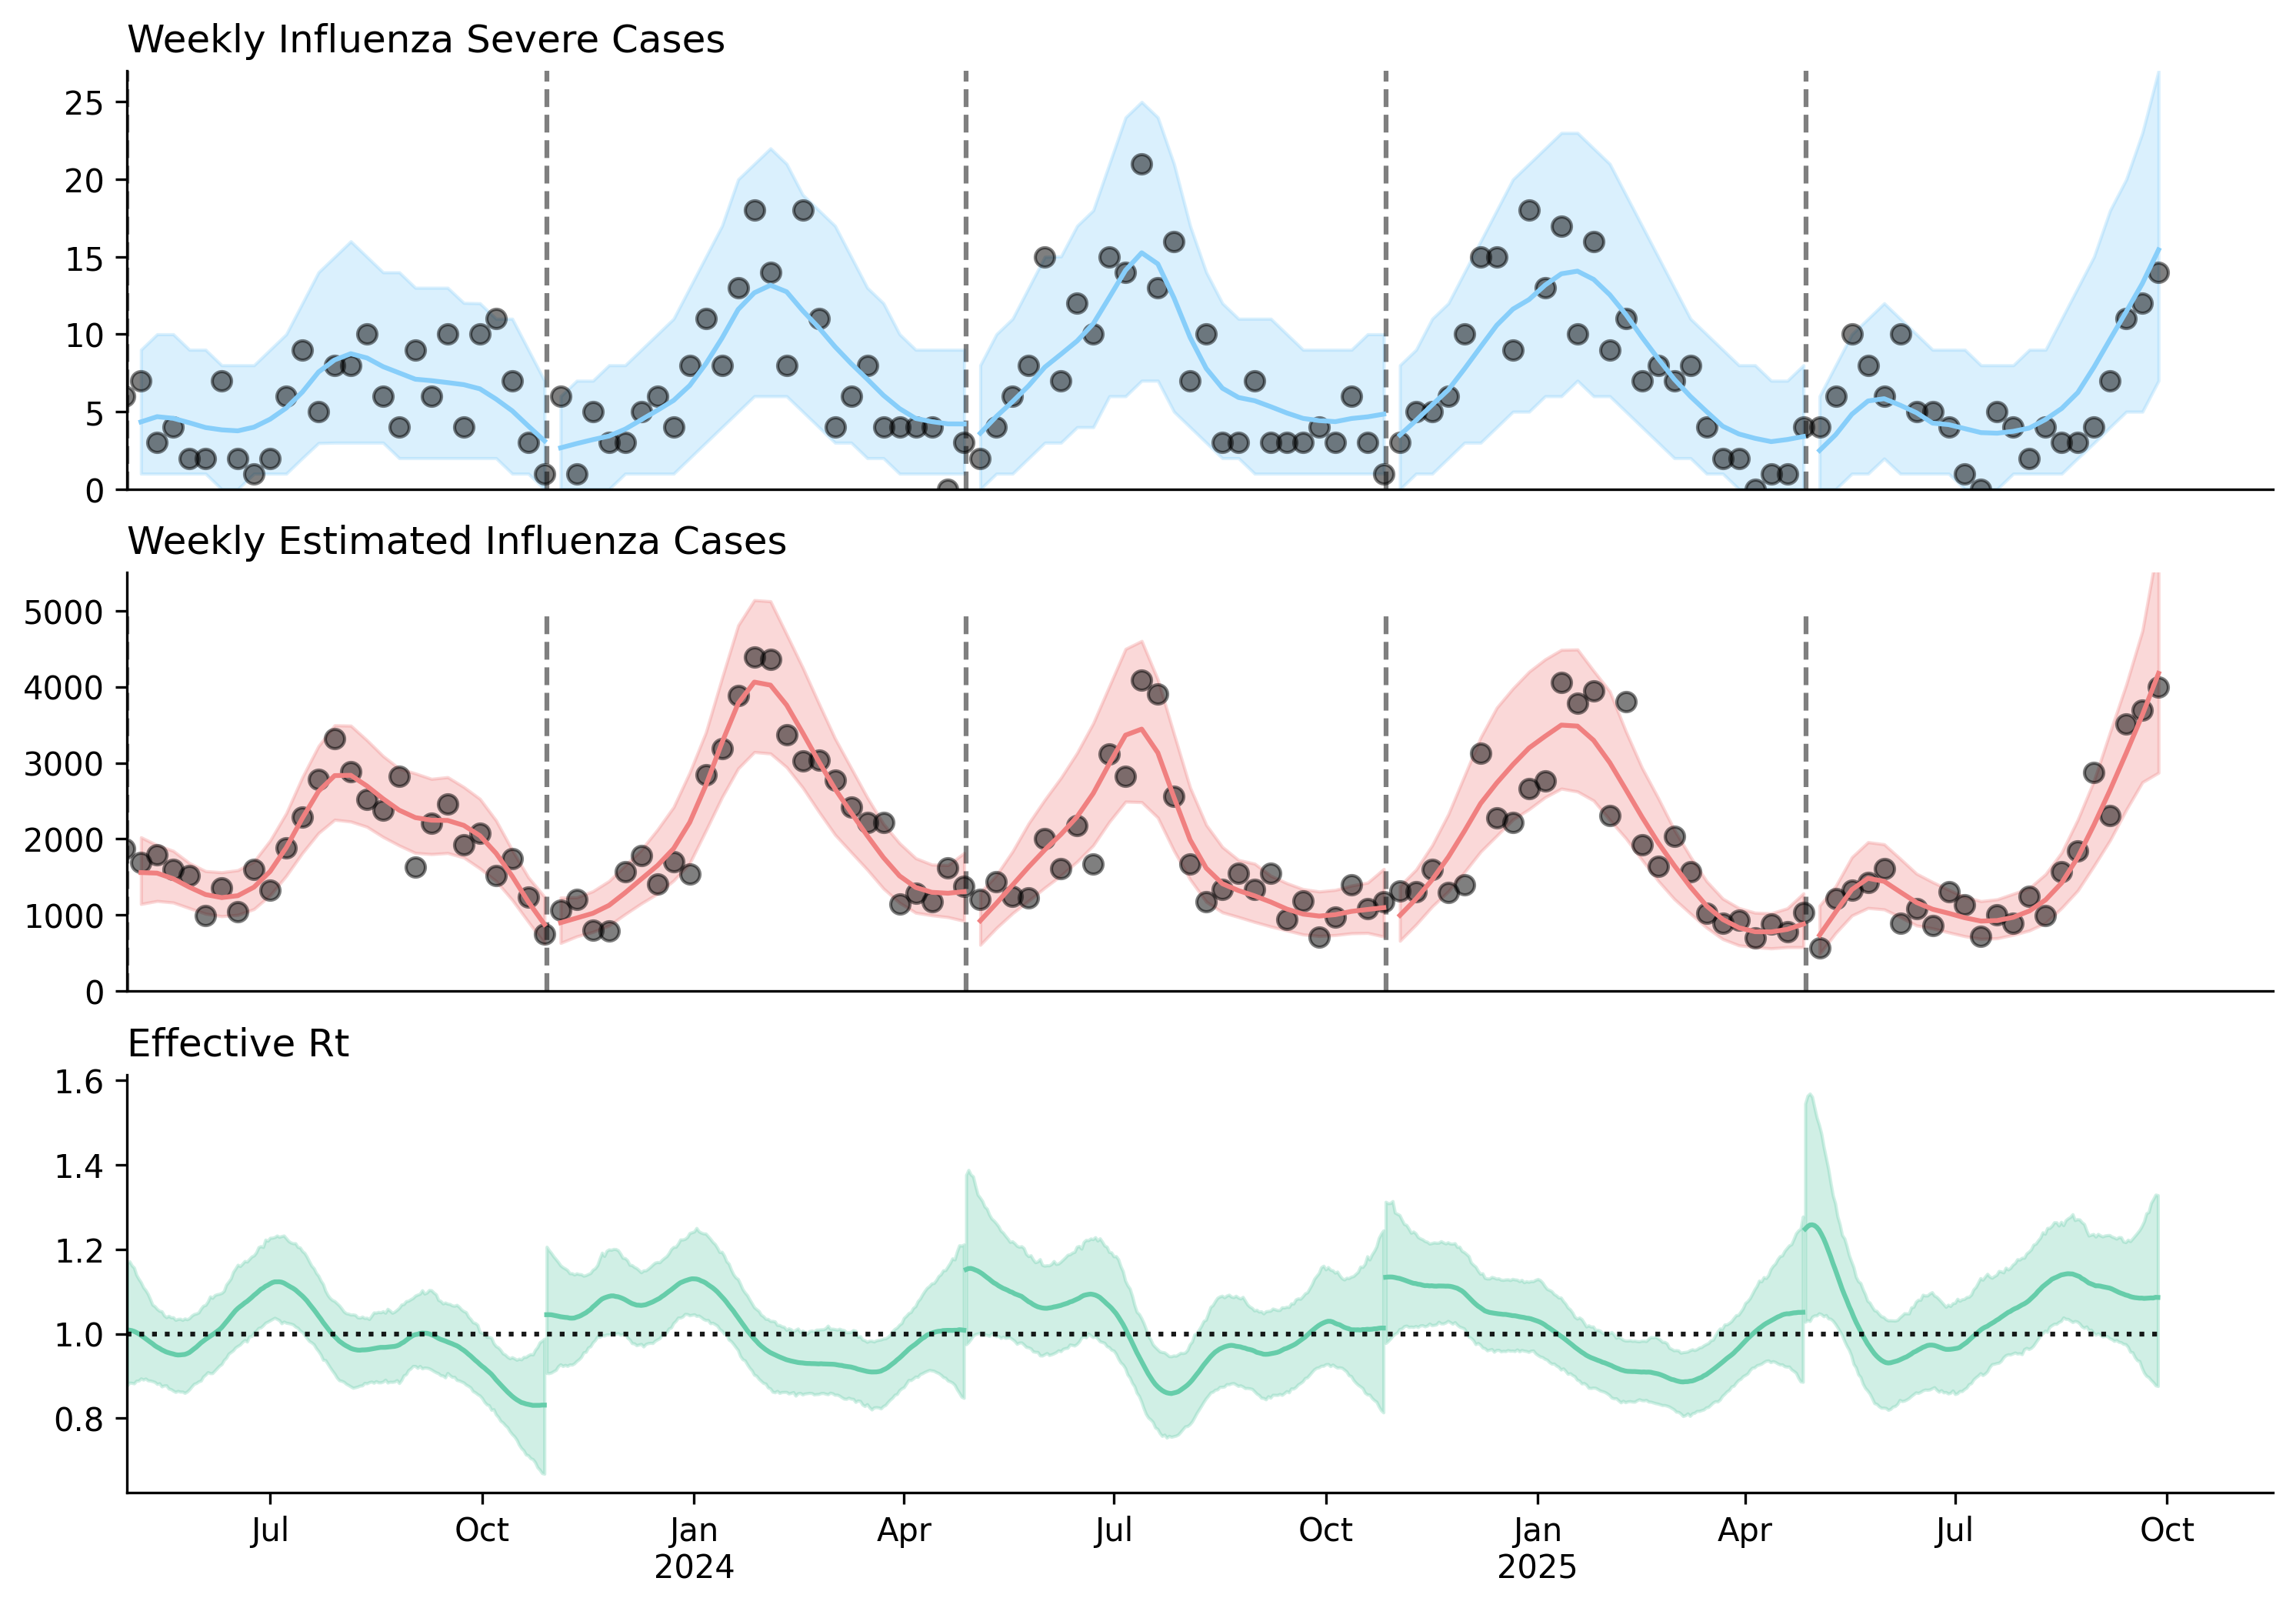

In [15]:
fig,ax = plt.subplots(3,1,figsize = (12,8),dpi=300)
plt.subplots_adjust(hspace = 0.2)

ax[0].plot(d['end_date'],d['severe_flu'], 'ko',alpha = 0.5)

for v in surv_period['start']:
        ax[0].vlines(x = d[d['year_week'] == v]['start_date'], ymin = 0, ymax = 30, linestyles='dashed', alpha = 0.5, color = 'black')
        ax[1].vlines(x = d[d['year_week'] == v]['start_date'], ymin = 0, ymax = 5000, linestyles='dashed', alpha = 0.5, color = 'black')

ax[0].set_ylim(0,27)
ax[0].set_xticks([])

ax[1].plot(d['end_date'],d['est_flu_cases'],'ko', alpha = 0.5)

ax[1].set_ylim(0,5500)
ax[1].set_xticks([])

for a in ax:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

for idx in range(len(res_list)):
        pred_pri = res_list[idx].posterior_predictive.negbinom_primary_rv.values.reshape(-1,len(res_list[idx].observed_data.negbinom_primary_rv.values),7).sum(axis=2)
        pred_sev = res_list[idx].posterior_predictive.negbinom_severe_rv.values.reshape(-1,len(res_list[idx].observed_data.negbinom_severe_rv.values),7).sum(axis=2)

        pred_pri_q = jnp.quantile(pred_pri, q = jnp.array([0.025,0.975]),axis=0)
        pred_sev_q = jnp.quantile(pred_sev, q = jnp.array([0.025,0.975]),axis=0)

        ax[0].plot(d_comb[idx]['end_date'],jnp.mean(pred_sev,axis=0), color = 'lightskyblue')
        ax[0].fill_between(d_comb[idx]['end_date'],pred_sev_q[0,],pred_sev_q[1,], color = 'lightskyblue', alpha = 0.3)

        ax[1].plot(d_comb[idx]['end_date'],jnp.mean(pred_pri,axis=0), color = 'lightcoral')
        ax[1].fill_between(d_comb[idx]['end_date'],pred_pri_q[0,],pred_pri_q[1,], color = 'lightcoral', alpha = 0.3)

        #Plot Rt
        xdate = pd.date_range(d_comb[idx]['start_date'].iloc[0],d_comb[idx]['end_date'].iloc[-1])
        est_rt = res_list[idx].posterior_predictive.Rt.values.reshape(-1,len(d_comb[idx]) * 7)
        rt_q = jnp.quantile(est_rt, q = jnp.array([0.025,0.975]),axis=0)

        ax[2].plot(xdate, jnp.mean(est_rt,axis=0), color = 'mediumaquamarine')
        ax[2].fill_between(xdate,rt_q[0,],rt_q[1,], color = 'mediumaquamarine', alpha = 0.3)

ax[2].hlines(y = 1.0, xmin = d['start_date'].iloc[0], xmax = d['end_date'].iloc[-1],linestyles='dotted', alpha = 0.9, color = 'black')

ax[0].set_title("Weekly Influenza Severe Cases", loc = 'left')
ax[1].set_title("Weekly Estimated Influenza Cases", loc = 'left')
ax[2].set_title("Effective Rt", loc = 'left')

format_quarterly_axis(ax[2])

for a in ax:
        a.set_xlim(pd.to_datetime('2023-04-30'))    
        
plt.show()

### Single period fits for test purposes (define d_sub first)

In [ ]:
fit_model = model.SeverePrimaryModel(
    latent_infections_rv=latent_inf,
    latent_severe_primary_rv=latent_severeprimary,
    I0_rv=I0,
    gen_int_rv=gen_time_rv,
    Rt_process_rv=rtproc,
    severe_admission_obs_process_rv=obs_sev,
    primary_care_cases_obs_process_rv=obs_primary
)

# Run MCMC
fit_model.run(
    num_samples=1000,
    num_warmup=1000,
    rng_key=jax.random.key(54),
    mcmc_args=dict(progress_bar=False, num_chains=2),
    data_observed_severe_admissions = d_sub['severe_flu'].values,
    data_observed_primary_care_cases = d_sub['est_flu_cases'].values,
    weekly_obs = True
    )

## (7) Posterior predictive and MCMC diagnostics
idata = az.from_numpyro(fit_model.mcmc)

## Posterior predictive checks
ppc_samples = fit_model.posterior_predictive(
    n_datapoints=len(d_sub) * 7
)

idata = az.from_numpyro(
    posterior=fit_model.mcmc,
    posterior_predictive=ppc_samples
)

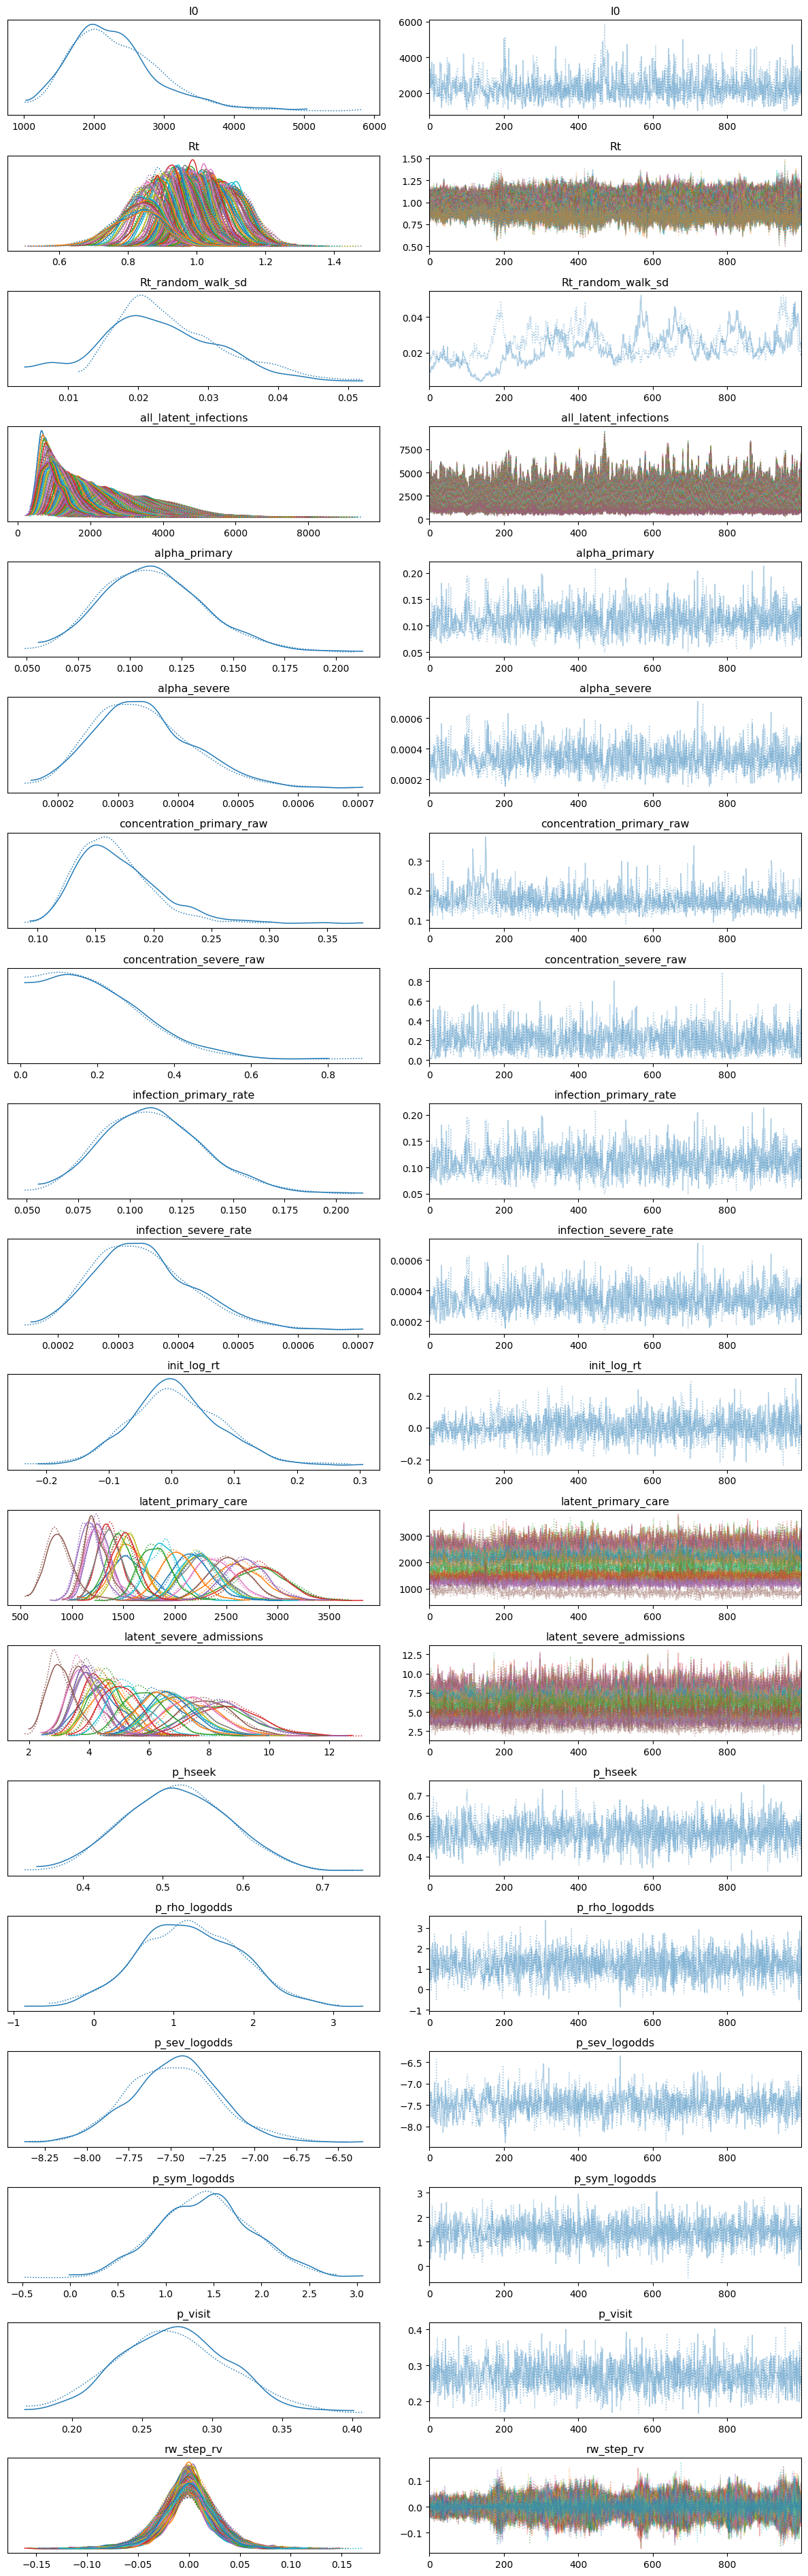

In [ ]:
# diagnostics
az.plot_trace(idata)

plt.tight_layout()
plt.show()

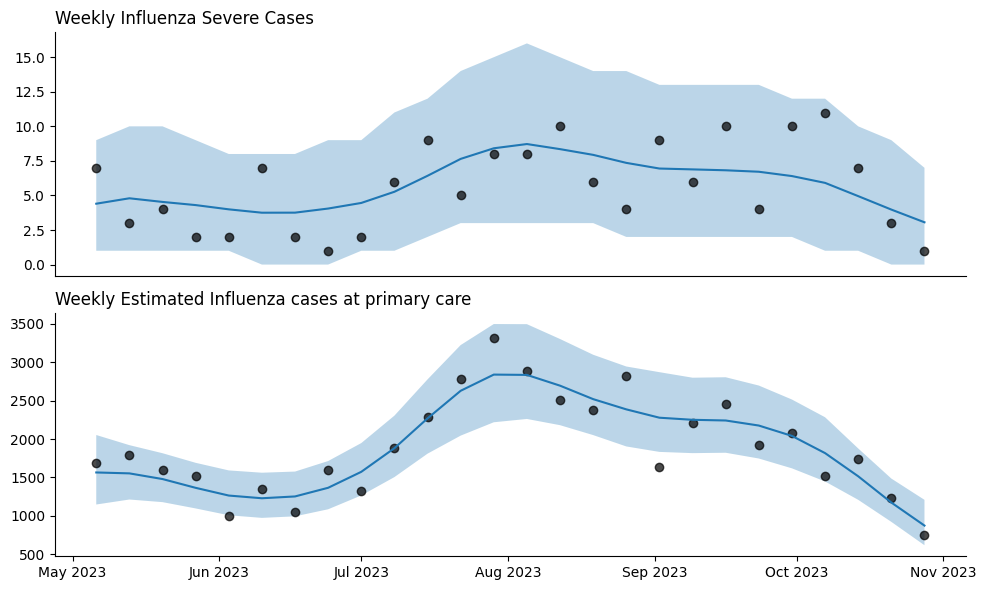

In [99]:
pred_pri = idata.posterior_predictive.negbinom_primary_rv.values.reshape(-1,len(d_sub),7).sum(axis=2)
pred_sev = idata.posterior_predictive.negbinom_severe_rv.values.reshape(-1,len(d_sub),7).sum(axis=2)

pred_pri_q = jnp.quantile(pred_pri, q = jnp.array([0.025,0.975]),axis=0)
pred_sev_q = jnp.quantile(pred_sev, q = jnp.array([0.025,0.975]),axis=0)

fig,ax = plt.subplots(2,1, figsize = (10,6))
fig.subplots_adjust(hspace = 0)

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    

ax[0].set_xticks([])

ax[0].plot(d_sub['end_date'],d_sub['severe_flu'],'ko', alpha = 0.7)
ax[1].plot(d_sub['end_date'],d_sub['est_flu_cases'],'ko', alpha = 0.7)

##PRED
ax[0].plot(d_sub['end_date'],jnp.mean(pred_sev, axis = 0))
ax[1].plot(d_sub['end_date'],jnp.mean(pred_pri, axis = 0))

ax[0].fill_between(d_sub['end_date'], pred_sev_q[0,], pred_sev_q[1,], alpha = 0.3)
ax[1].fill_between(d_sub['end_date'], pred_pri_q[0,], pred_pri_q[1,], alpha = 0.3)

ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax[0].set_title('Weekly Influenza Severe Cases',loc = 'left')
ax[1].set_title('Weekly Estimated Influenza cases at primary care', loc = 'left')

plt.tight_layout()
plt.show()

### Forecasts